# Bubble Correlations

In [2]:
import numpy as np
import math
import statistics as stat
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
from itertools import cycle
import random
from numpy import load
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import ticker
from collections import OrderedDict
import matplotlib.colors as mcolors
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d

In [3]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [4]:
nLat = 8192
nTime = 256
nSims = 30000
nSims0 = 0
simStep = 1000
splitdata = np.arange(nSims0, nSims+1, 1000); print('splitdata ', splitdata)

nu = 2.*10**(-3)
lenLat = 8 * 0.5 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
def m2eff(lamb):
    return 4. * nu * (- 1. + lamb**2)

phi_initial = np.pi
nyq = nLat//2+1; spec = nyq//16; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 16.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)
unit_conv = nLat/nTime/alpha; print('units = ', unit_conv)

ignore = 2
tcheck = lambda lamb: int(ignore/np.sqrt(m2eff(lamb))/dtout)
tTime = lambda lamb: nTime - tcheck(lamb)

splitdata  [    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000
 24000 25000 26000 27000 28000 29000 30000]
lenLat =  3162.2776601683795
dx, dk, spec  0.3860202221885229 0.0019869176531592202 256
dtout/dt =  32.0
light_cone =  2
units =  2.0


### Import the Data 

In [4]:
#correlator = 
#np.save(thrcorr_file(2, list_threshold[2], list_phi0[2], list_lamb[2]), correlator)

In [5]:
plots_file = '/home/dpirvu/big_plot_file/new_new_bubble_correlations/'
pickle_file = '/home/dpirvu/pickle_location/new_new_bubble_correlations/'

def sim_location(sim):
    return '/gpfs/dpirvu/bubble_correlations/t'+str(nTime)+'_x'+str(nLat)+'_len{:.4f}'.format(lenLat)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_alph{:.4f}'.format(alpha)+'_spec'+str(spec)+'_sim'+str(sim)+'_fields.dat'
def sim_suffix(phi0, lamb):
    return '_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)
def pickle_location(phi0, lamb):
    return pickle_file + 'phi0'+str(int(20*np.pi/phi0))+'_lambda'+str(int(10*lamb))+'/'
def pickle_corr_location(phi0, lamb, type):
    return pickle_file + 'th_correlator_type'+type+'_phi0'+str(int(20*np.pi/phi0))+'_lambda'+str(int(10*lamb))
def thrcorr_file(type, threshold, phi0, lamb):
    return pickle_file+'thcorr_type'+str(type)+'_threshold'+str(threshold)+'_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'.npy'

def data_file_1D(data_vec, xstep, multiplier, phi0, lamb, filter, deltat):
    x = ''
    for type in data_vec:
        x += str(type) #'null_'+
    return pickle_file+'1d_type'+x+'_xstep'+str(xstep)+'_deltat'+str(deltat)+'_multiplier'+str(multiplier)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_filter{:.4f}'.format(filter)+'.npy'
def data_file_2D(type, xstep, tstep, phi0, lamb, filter):
    return pickle_file+'2d_type'+str(type)+'_xstep'+str(xstep)+'_tstep'+str(tstep)+'_for_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_filter{:.4f}'.format(filter)+'.npy'

def positive_data_file(phi0, lamb, minSim, maxSim, multiplier, filter):
    pickle = pickle_location(phi0, lamb)
    suffix = sim_suffix(phi0, lamb)
    return pickle+'positive_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'
def negative_data_file(phi0, lamb, minSim, maxSim, multiplier, filter):
    pickle = pickle_location(phi0, lamb)
    suffix = sim_suffix(phi0, lamb)
    return pickle+'negative_targets_sims'+str(minSim)+'_to'+str(maxSim-1)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+suffix+'.npy'

def round_to_n(x, n):
    return x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

def import_all_data(lamb, phi0, multiplier, filter):
    postlist = np.concatenate(tuple([np.load(positive_data_file(phi0, lamb, minSim, maxSim, multiplier, filter)) for minSim, maxSim in zip(splitdata, splitdata[1:])]))
    negtlist = np.concatenate(tuple([np.load(negative_data_file(phi0, lamb, minSim, maxSim, multiplier, filter)) for minSim, maxSim in zip(splitdata, splitdata[1:])]))
    postlist = [[i for i in simlist if i[0] > tcheck(lamb)] for simlist in postlist]
    negtlist = [[i for i in simlist if i[0] > tcheck(lamb)] for simlist in negtlist]
    return postlist, negtlist

[4.658106296918165, 4.759673735059503, 4.861241173200842]
[1.51651364 1.61808108 1.71964852]


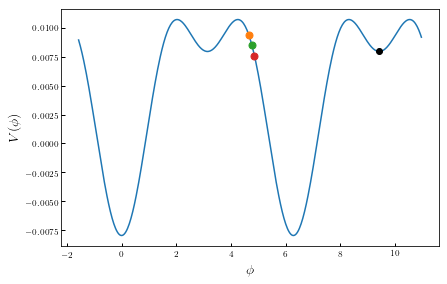

In [6]:
def V(phi, lamb=1.5):
    return ( -np.cos(phi) + 0.5 * lamb**2 * np.sin(phi)**2 ) * 4 * nu
right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')

list_multiplier, list_threshold= [], []
list_type = ['++', '--', '++--', '+-', '-+']
thcorr = ['++', 'foo', '++--', '+-', 'foo']
list_data_plot = [0, 2, 1]
list_title_type = [r'$\xi^{++}_{bb}(t,r)$', r'$\xi^{--}_{bb}(t,r)$', r'$\xi^{overall}_{bb}(t,r)$', r'$\xi^{+-}_{bb}(t,r)$', r'$\xi^{-+}_{bb}(t,r)$']

list_phi0 = [2*np.pi/6.6, 2*np.pi/7., 2*np.pi/6.6]#[1:2]
list_phi0_title = np.asarray(list_phi0)*np.sqrt(2)
list_lamb = [1.5, 1.5, 1.6]#[1:2]

filter_size1 = 39.39920611359256/4.
filter_size2 = 20.597556445406827
filter_size3 = 39.39920611359256

list_multiplier, list_threshold= [], []
for multiplier in [0.2, 0.25, 0.3]:
#for multiplier in [0.1, 0.2, 0.3]:
    threshold = right_phi_at_V_max.x + np.abs(right_phi_at_V_max.x-2*phi_initial)*multiplier
    list_multiplier.append(multiplier)
    list_threshold.append(threshold)
print(list_threshold)
print((np.asarray(list_threshold)-np.pi))

def Rrange(min, max, step):
    return np.arange(min, max+1, step)
def Trange(min, max, step):
    return np.arange(min, max+1, step)

fig, ax = plt.subplots(figsize=(7,4))
plt.plot([i for i in np.arange(-np.pi/2, 3.5*phi_initial, phi_initial/100)], [V(i) for i in np.arange(-np.pi/2, 3.5*phi_initial, phi_initial/100)])
[plt.plot(i, V(i), 'o', ms = 7) for i in list_threshold]
ax.tick_params(direction='in', width='1')
plt.plot(3*np.pi, V(3*np.pi), 'ko')
plt.xlabel(r'$\phi$', fontsize=14); plt.ylabel(r'$V(\phi)$', fontsize=14); plt.show()

### Correlation Functions

In [7]:
def get_numdens(data, multiplier, threshold, phi0, lamb, filter):
    PositiveTargets, NegativeTargets = import_all_data(lamb, phi0, multiplier, filter)
    simVol = nLat * tTime(lamb)
    if data == 0:
        allTargets = PositiveTargets + NegativeTargets
        nSims = len(allTargets)
        nBubs = np.asarray([len(ii) for ii in allTargets])
    elif data == 1:
        allTargets = [PositiveTargets[sim] + NegativeTargets[sim] for sim in range(len(PositiveTargets))]
        nSims = len(allTargets)
        nBubs = np.asarray([len(ii) for ii in allTargets])
    elif data == 2:
        allTargets = PositiveTargets + NegativeTargets
        nSims = len(allTargets)
        nBubs = np.asarray([len(ii)+1 for ii in allTargets])
    return sum(nBubs) / nSims / simVol

In [8]:
def correlator(lamb, data, PositiveTargets, NegativeTargets, R, RR, T, TT, bubNDens):
    DCorrelator = []
    if data == 0:
        allTargets = PositiveTargets + NegativeTargets
    elif data == 1:
        allTargets = [PositiveTargets[sim] + NegativeTargets[sim] for sim in range(len(PositiveTargets))]

    area = 2 * np.abs(RR-R) * np.abs(TT-T)
    for sim in range(len(allTargets)):
        bubbleCoords = np.asarray(allTargets[sim])
        nBubbles = len(bubbleCoords)
        bubCounter = 0.

#        nullCoords = np.asarray(list(OrderedDict.fromkeys(random.choices(np.arange(int(nLat//2)), k = 50*nBubbles))))
#        nNull = len(nullCoords)
#                nndx = np.abs(bubbleCoords[bubloc,1] - nullCoords[:])
#                nullCounter += len([l for l in range(len(nndx)) if (R <= nndx[l] < RR)])
#            if nullCounter > 0:
#                DCorrelator.append( (bubCounter * nNull) / (nullCounter * nBubbles) )

        if nBubbles > 0:
            for bubloc in range(nBubbles):
                bdt = bubbleCoords[bubloc,0] - bubbleCoords[:,0]
                bdx = np.abs(bubbleCoords[bubloc,1] - bubbleCoords[:,1])
                bdx[bdx > nLat//2] = nLat - bdx[bdx > nLat//2]
                bubCounter += len([l for l in range(len(bdx)) if (R <= bdx[l] < RR and T <= bdt[l] < TT)])
            DCorrelator.append( bubCounter / nBubbles )
    return np.mean(DCorrelator) / area / bubNDens - 1.

def mixed_correlator(lamb, PositiveTargets, NegativeTargets, R, RR, T, TT, bubNDens):
    DCorrelator = []
    area = 2 * np.abs(RR-R) * np.abs(TT-T)
    for sim in range(len(PositiveTargets)):
        posBubbleCoords, negBubbleCoords = np.asarray(PositiveTargets[sim]), np.asarray(NegativeTargets[sim])
        nPosBubbles, nNegBubbles = len(posBubbleCoords), len(negBubbleCoords)
        bubCounterN, bubCounterP = 0., 0.

        if nPosBubbles > 0 and nNegBubbles > 1:
            for bubloc in range(nPosBubbles):
                pbdt = posBubbleCoords[bubloc,0] - negBubbleCoords[:,0]
                pbdx = np.abs(posBubbleCoords[bubloc,1] - negBubbleCoords[:,1])
                pbdx[pbdx > nLat//2] = nLat - pbdx[pbdx > nLat//2]
                bubCounterN += len([l for l in range(len(pbdx)) if (R <= pbdx[l] < RR and T <= pbdt[l] < TT)])
            DCorrelator.append( bubCounterN / (nNegBubbles + 1.) )

        if nPosBubbles > 1 and nNegBubbles > 0:
            for bubloc in range(nNegBubbles):
                nbdt = negBubbleCoords[bubloc,0] - posBubbleCoords[:,0]
                nbdx = np.abs(negBubbleCoords[bubloc,1] - posBubbleCoords[:,1])
                nbdx[nbdx > nLat//2] = nLat - nbdx[nbdx > nLat//2]
                bubCounterP += len([l for l in range(len(nbdx)) if (R <= nbdx[l] < RR and T <= nbdt[l] < TT)])
            DCorrelator.append( bubCounterP / (nPosBubbles + 1.) )
    return np.mean(DCorrelator) / area / bubNDens - 1.
    
def empirical_corr_and_err(data, phi0, lamb, multiplier, filter, R, RR, T, TT, simStep, nDensGlobal):
    counter = []
    PositiveTargets, NegativeTargets = import_all_data(lamb, phi0, multiplier, filter)
    batches = np.arange(0, len(PositiveTargets)+1, simStep)
    for sim_min, sim_max in zip(batches[:-1:], batches[1:]):
        posTGS = PositiveTargets[sim_min:sim_max]
        negTGS = NegativeTargets[sim_min:sim_max]
        if data in [0, 1]:
            counter.append(correlator(lamb, data, posTGS, negTGS, R, RR, T, TT, nDensGlobal))
        else:
            counter.append(mixed_correlator(lamb, posTGS, negTGS, R, RR, T, TT, nDensGlobal))
    return np.nanmean(counter), np.std(counter)/np.sqrt(len(counter))

def correlation_functions(multiplier, threshold, phi0, lamb, filter, data_vec, xrange, T, TT, simStep):
    corr_vec = []
    for data in data_vec:
        nDensGlobal = get_numdens(data, multiplier, threshold, phi0, lamb, filter)
        res = [empirical_corr_and_err(data, phi0, lamb, multiplier, filter, R, RR, T, TT, simStep, nDensGlobal) for R, RR in zip(xrange[:-1:], xrange[1:])]
        corr_vec.append(res)
    return np.asarray(corr_vec)

def spacetime_correlator(phi0, lamb, filter, data, xrange, trange):
    valmin, valmax = 0, 0
    matrix_vec = []
    for multiplier, threshold in zip(list_multiplier, list_threshold):
        PositiveTargets, NegativeTargets = import_all_data(lamb, phi0, multiplier, filter)
        matrix = np.asarray([[-1.]*len(xrange[:-1])]*len(trange[:-1]))
        nDensGlobal = [get_numdens(data, multiplier, threshold, phi0, lamb, filter) for data in [0,1,2]]
        for tind in range(len(trange[:-1])):
            T, TT = trange[:-1][tind], trange[1:][tind]
            for xind in range(len(xrange[:-1])):
                R, RR = xrange[:-1][xind], xrange[1:][xind]
                if data in [0, 1]:
                    corr_func = correlator(lamb, data, PositiveTargets, NegativeTargets, R, RR, T, TT, nDensGlobal[data])
                else:
                    corr_func = mixed_correlator(lamb, PositiveTargets, NegativeTargets, R, RR, T, TT, nDensGlobal[data])
                matrix[tind, xind] = corr_func
        matrix_vec.append(matrix)
    return np.asarray(matrix_vec)

### One-Dimensional Correlators 

In [2]:
xmin = 1
xmax = nLat//8
Tmin = 0
Tmax = 1

for xstep, smoothing in zip([20, 40, 80][::], [filter_size1, filter_size2, filter_size3][::]):
    xrange = Rrange(xmin, xmax, xstep)
    for multiplier, threshold in zip(list_multiplier[:], list_threshold[:]):
        data_vec = [0,1,2]
        for phi0, lamb in zip(list_phi0, list_lamb):
            corr_data = correlation_functions(multiplier, threshold, phi0, lamb, smoothing, data_vec, xrange, Tmin, Tmax, simStep)
            np.save(data_file_1D(data_vec, xstep, multiplier, phi0, lamb, smoothing, np.abs(Tmax-Tmin)), corr_data)
            print('Done')

### Two-Dimensional Correlators 

In [1]:
#xmax = 400
#xmin = 1
#tmax = 71
#tmin = -70
#tstep = 3
#trange = Trange(tmin, tmax, tstep)

#for xstep, smoothing in zip([5, 10][:1], [filter_size1, filter_size2][:1]):
#    xrange = Rrange(xmin, xmax, xstep)
#    for phi0, lamb in zip(list_phi0[1::], list_lamb[1::]):
#        corr_data = spacetime_correlator(phi0, lamb, smoothing, 0, xrange, trange)
#       np.save(data_file_2D(0, xstep, tstep, phi0, lamb, smoothing), corr_data)
#        print('Done')